In [1]:
import os
import h5py 
import glob
import numpy as np
from tqdm import tqdm

In [2]:
os.sys.path.append(os.getcwd().replace('/nb', '/bin'))
import svda as SVDA

In [3]:
from astropy import units as U
from astropy.cosmology import Planck13
from scipy.interpolate import interp1d

In [4]:
from provabgs import util as UT
from provabgs import infer as Infer
from provabgs import models as Models

In [5]:
from speclite import filters as specFilter

In [6]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False


Bad key text.latex.preview in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95 

In [7]:
r_pass = specFilter.load_filters('decam2014-r')

def r_mag(w, f):
    ''' calculate r-band magnitude given w, f
    '''
    flux_z, w_z = r_pass.pad_spectrum(np.atleast_2d(f) * 1e-17*U.erg/U.s/U.cm**2/U.Angstrom, w * U.Angstrom)
    maggies = r_pass.get_ab_maggies(flux_z, wavelength=w_z)
    return 22.5 - 2.5 * np.log10(maggies.as_array()[0][0] * 1e9)


def bgs_faint_color_cut(hpix):
    ''' if True:    rfib < 20.75
        if False:   rfib < 21.5

    also return r-band fiber fraction
    '''
    _x = SVDA.healpix(hpix, target='BGS_FAINT', redux='fuji', survey='sv3')
    coadd = _x[0]

    trans_g = SVDA.mwdust_transmission(coadd['EBV'], 'g',
            np.array(coadd['PHOTSYS']).astype(str),
            match_legacy_surveys=False)
    trans_r = SVDA.mwdust_transmission(coadd['EBV'], 'r',
            np.array(coadd['PHOTSYS']).astype(str),
            match_legacy_surveys=False)
    trans_z = SVDA.mwdust_transmission(coadd['EBV'], 'z',
            np.array(coadd['PHOTSYS']).astype(str),
            match_legacy_surveys=False)
    trans_w = SVDA.mwdust_transmission(coadd['EBV'], 'w1',
            np.array(coadd['PHOTSYS']).astype(str),
            match_legacy_surveys=False)

    g = 22.5 - 2.5*np.log10((coadd['FLUX_G'] / trans_g).clip(1e-16))
    r = 22.5 - 2.5*np.log10((coadd['FLUX_R'] / trans_r).clip(1e-16))
    z = 22.5 - 2.5*np.log10((coadd['FLUX_Z'] / trans_z).clip(1e-16))
    w1 = 22.5 - 2.5*np.log10((coadd['FLUX_W1'] / trans_w).clip(1e-16))

    schlegel_color = (z - w1) - 3/2.5 * (g - r) + 1.2

    return schlegel_color < 0., coadd['FIBERFLUX_R']/coadd['FLUX_R']

In [8]:
m_nmf = Models.NMF(burst=True, emulator=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [9]:
dat_dir = '/global/cfs/cdirs/desi/users/chahah/provabgs/svda/'

In [10]:
hpixs = [int(f.split('-')[3].split('.')[0]) for f in glob.glob(os.path.join(dat_dir, 'provabgs-*.BGS_BRIGHT.hdf5'))]
print('%i healpixels' % len(hpixs))

369 healpixels


In [11]:
hpix = hpixs[0]
#print(f'healpix {hpix}')
# read posteriors in healpix
with h5py.File(os.path.join(dat_dir, 'provabgs-sv3-bright-%i.BGS_BRIGHT.hdf5' % hpix), 'r') as fhpix: 
    #if 'zmax' in fpost.keys(): continue 
    if 'redshift' not in fhpix.keys(): 
        print()
        print('%i is problematic' % hpix)
        print()
        raise ValueError

    zreds   = fhpix['redshift'][...]
    if len(zreds) == 0: raise ValueError

    targids = fhpix['targetid'][...]

    _logp   = fhpix['log_prob'][...]
    _logp   = _logp.reshape((_logp.shape[0], _logp.shape[1] * _logp.shape[2]))

    _theta  = fhpix['samples'][...]
    _theta  = _theta.reshape((_theta.shape[0], _theta.shape[1] * _theta.shape[2], _theta.shape[3]))

    theta_bfs = np.array([tt[imax,:] for imax, tt in zip(np.argmax(_logp, axis=1), _theta)])

In [41]:
i = 0 
zred, theta_bf = zreds[i], theta_bfs[i] 

z_arr = np.array([zred, 0.3, 0.4, 0.6]) 
dlz = Planck13.luminosity_distance(z_arr).to(U.cm).value

# get best-fit SED 
w, f = m_nmf.sed(theta_bf[:-1], zred)

w_z = w / (1. + zred) * (1 + z_arr[:,None])
f_z = f * ((dlz[0]**2 / dlz**2) * (1 + zred)/(1 + z_arr))[:,None]

In [42]:
r_arr = np.array([r_mag(_w, _f) for _w, _f in zip(w_z, f_z)])

[]

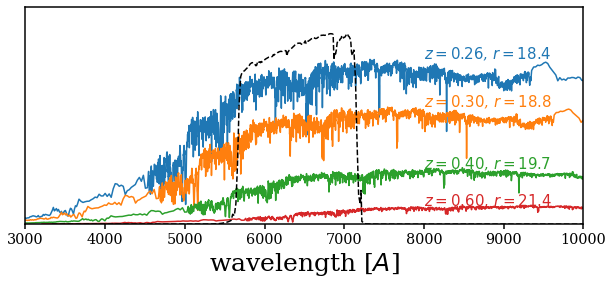

In [44]:
fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(111)
for i in range(len(z_arr)): 
    sub.plot(w_z[i], f_z[i])
    sub.text(8000, np.max(f_z[i]), '$z = %.2f$, $r = %.1f$' % (z_arr[i], r_arr[i]), color='C%i' % i, 
             fontsize=15)

sub.plot(r_pass[0]._wavelength, 30*r_pass[0].response, c='k', ls='--')
sub.set_xlabel('wavelength [$A$]', fontsize=25)
sub.set_xlim(3e3, 1e4)
sub.set_ylim(0., 18)
sub.set_yticks([])